In [865]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import plotly.express as px
from datetime import datetime,timedelta  
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.metrics import adjusted_rand_score
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')


In [866]:
def load_and_process_data():
    data = pd.read_csv('./données_exp4.csv', sep=',', parse_dates=['order_purchase_timestamp'])
    return data

In [867]:
#RFM
def calculate_rfm_values(data, start_date):
    monetary = data.groupby('customer_unique_id')['total_value'].sum()
    frequency = data.groupby('customer_unique_id')['order_id'].nunique()
    last_purchase = data.groupby('customer_unique_id')['order_purchase_timestamp'].max()
    recency = (start_date - last_purchase).dt.days
    rfm_data = pd.DataFrame({'recency': recency, 'frequency': frequency, 'monetary': monetary})
    return rfm_data


In [868]:
def standardize_data(data):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)
    #standardized_data = pd.DataFrame(standardized_data, index=data.index, columns=data.columns)
    return standardized_data


1) entraîner le modèle sur les données de la période de base.
2) augmenter le délai de recherche d'une semaine/mois.
3) recalculer les données RFM en tenant compte des données ajoutées.
4) entraîner le modèle sur les données actuelles (kmean_current )
5) forcer les deux modèles (base(kmeans_ref) et current(current_kmeans)) à prédire les données d'entraînement
   en utilisant les données actuelles (current_rfm_values)
6) calculez l'ARI et passez à l'itération suivante.

In [869]:
def evaluate_cluster_stability_over_time_months(data, initial_training_period=pd.DateOffset(months=16), freq='M', random_state=42):
    data = data.sort_values('order_purchase_timestamp')
    max_date = data['order_purchase_timestamp'].max()
    start_date = max_date - initial_training_period
    training_data = data[data['order_purchase_timestamp'] <= start_date]

    rfm_values = calculate_rfm_values(training_data, start_date)
    standardized_rfm_values = standardize_data(rfm_values)
    #kmeans_ref = KMeans(n_clusters=optimal_number_of_clusters(standardized_rfm_values), random_state=random_state).fit(standardized_rfm_values)
    kmeans_ref = KMeans(n_clusters=4, random_state=random_state).fit(standardized_rfm_values)

    ars_scores = {}
    date_range = pd.date_range(start=start_date, end=max_date, freq=freq)

    for current_date in date_range:
        current_data = data[data['order_purchase_timestamp'] <= current_date]
        
        current_rfm_values = calculate_rfm_values(current_data, current_date)
        standardized_current_rfm_values = standardize_data(current_rfm_values)
    
        current_kmeans = KMeans(n_clusters=4, random_state=random_state).fit(standardized_current_rfm_values)

        ref_labels = kmeans_ref.predict(standardized_current_rfm_values)
        current_labels = current_kmeans.predict(standardized_current_rfm_values)
    
        ars = adjusted_rand_score(ref_labels, current_labels)
    
        print(f'Adjusted Rand Score for end date {current_date}: {ars}')
       
        ars_scores[current_date] = ars
        kmeans_ref = current_kmeans
        print(current_rfm_values.sort_values('recency'))
    
        current_rfm_values['Cluster'] = current_labels
        print(current_rfm_values.groupby('Cluster').describe().T)
    return ars_scores

In [870]:
ars_scores_months = evaluate_cluster_stability_over_time_months(data)
times, scores = zip(*ars_scores_months.items())

Adjusted Rand Score for end date 2017-05-31 09:06:57: 0.821322805992483
                                  recency  frequency  monetary
customer_unique_id                                            
c230d0a507ccf302b339305e2acf3376        0          1   1058.10
6e1550b8966f327f29bc06b18972dbec        0          2   1122.61
874d66ce189a3f4df3ab268698e2a211        0          1    167.81
4067ba7df47a2bcb753ae5f7530fc7cc        0          2    176.21
c1c0e094a7fbde66794da6ee9f9d1dda        0          1    361.04
...                                   ...        ...       ...
32ea3bdedab835c3aa6cb68ce66565ef      239          1     45.46
87776adb449c551e74c13fc34f036105      239          1     40.95
0eb1ee9dba87f5b36b4613a65074337c      240          1    109.34
4854e9b3feff728c13ee5fc7d1547e92      268          1     75.06
b7d76e111c89f7ebf14761390f0f7d17      268          1    136.23

[10800 rows x 3 columns]
Cluster                    0            1             2            3
recency   coun

Adjusted Rand Score for end date 2017-09-30 09:06:57: 0.9608631569570206
                                  recency  frequency  monetary
customer_unique_id                                            
9062d3e575a476f5f3ffa8abf125fd42        0          1     32.09
0b28ba51b9306655b752f66c3b2d3b94        0          1    351.96
55c9c33a35951c830b7025a819db5950        0          1    126.22
462483c5762cc99a7c728dc2cfb8aaf6        0          1     72.16
62a90409f4c921a01d4422c4f79a0543        0          1     40.09
...                                   ...        ...       ...
7390ed59fa1febbfda31a80b4318c8cb      361          1    154.57
10e89fd8e5c745f81bec101207ba4d7d      361          1     92.27
0eb1ee9dba87f5b36b4613a65074337c      362          1    109.34
4854e9b3feff728c13ee5fc7d1547e92      390          1     75.06
b7d76e111c89f7ebf14761390f0f7d17      390          1    136.23

[25679 rows x 3 columns]
Cluster                     0             1             2            3
recency   c

Adjusted Rand Score for end date 2018-01-31 09:06:57: 0.9994966890831547
                                  recency  frequency  monetary
customer_unique_id                                            
680f6342172f7caa8fe7fc08f30da574        0          1     87.14
c6b1d0d394ba367ae48f9bb69158231b        0          1   1628.60
de5f6712ccc81b109504d3abcf6ec094        0          1     61.85
757c1f54f0e618e1736fcee19a0e4fcf        0          1     98.79
9e98058daf211d4d993b00343d65d561        0          1    181.26
...                                   ...        ...       ...
87776adb449c551e74c13fc34f036105      484          1     40.95
8d3a54507421dbd2ce0a1d58046826e0      484          1    133.46
0eb1ee9dba87f5b36b4613a65074337c      485          1    109.34
b7d76e111c89f7ebf14761390f0f7d17      513          1    136.23
4854e9b3feff728c13ee5fc7d1547e92      513          1     75.06

[48955 rows x 3 columns]
Cluster                     0            1             2             3
recency   c

Adjusted Rand Score for end date 2018-05-31 09:06:57: 0.9838331496583851
                                  recency  frequency  monetary
customer_unique_id                                            
142dc6250eac579893595d9889411834        0          1    128.67
843b52855a59201d7f3939d6c87d34be        0          1     43.38
6f44e0e9c2553c98d619d8c5394f984f        0          1     65.13
84410ad07e78177b871bb6eab223499d        0          1    192.19
809ecdd6011f1787f73bef179ce2a63a        0          1    227.26
...                                   ...        ...       ...
61db744d2f835035a5625b59350c6b63      604          1     53.73
7390ed59fa1febbfda31a80b4318c8cb      604          1    154.57
0eb1ee9dba87f5b36b4613a65074337c      605          1    109.34
b7d76e111c89f7ebf14761390f0f7d17      633          1    136.23
4854e9b3feff728c13ee5fc7d1547e92      633          1     75.06

[75227 rows x 3 columns]
Cluster                     0             1            2             3
recency   c

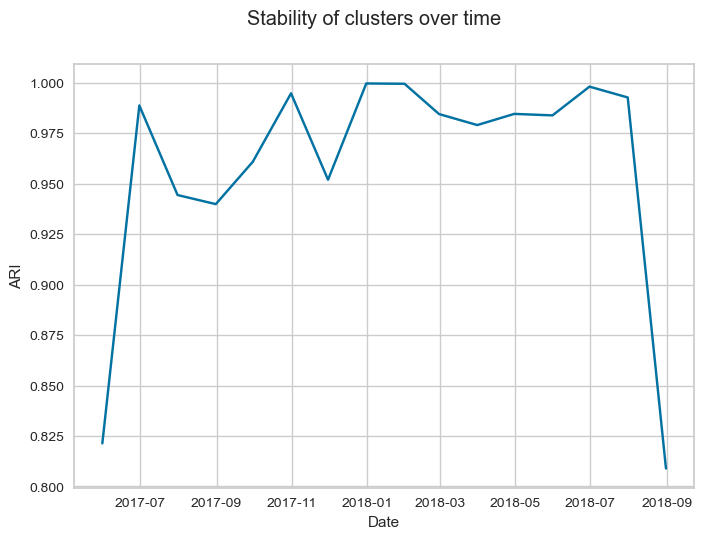

In [871]:
ari_df1 = pd.DataFrame(list(ars_scores_months.items()), columns=['Date', 'ARI'])
sns.lineplot(data=ari_df1, x='Date', y='ARI')
plt.suptitle('Stability of clusters over time')
plt.show()


In [872]:
def evaluate_cluster_stability_over_time(data, initial_training_period=pd.DateOffset(months=6), freq='W', random_state=42):
    data = data.sort_values('order_purchase_timestamp')
    max_date = data['order_purchase_timestamp'].max()
    start_date = max_date - initial_training_period
    training_data = data[data['order_purchase_timestamp'] <= start_date]

    rfm_values = calculate_rfm_values(training_data, start_date)
    standardized_rfm_values = standardize_data(rfm_values)
    kmeans_ref = KMeans(n_clusters=4, random_state=random_state).fit(standardized_rfm_values)

    ars_scores = {}
    date_range = pd.date_range(start=start_date, end=max_date, freq=freq)

    for current_date in date_range:
        current_data = data[data['order_purchase_timestamp'] <= current_date]
        
        current_rfm_values = calculate_rfm_values(current_data, current_date)
        standardized_current_rfm_values = standardize_data(current_rfm_values)
    
        current_kmeans = KMeans(n_clusters=4, random_state=random_state).fit(standardized_current_rfm_values)

        ref_labels = kmeans_ref.predict(standardized_current_rfm_values)
        current_labels = current_kmeans.predict(standardized_current_rfm_values)
    
        ars = adjusted_rand_score(ref_labels, current_labels)
    
        print(f'Adjusted Rand Score for end date {current_date}: {ars}')
       
        ars_scores[current_date] = ars
        kmeans_ref = current_kmeans
        print(current_rfm_values.sort_values('recency'))
    
        current_rfm_values['Cluster'] = current_labels
        print(current_rfm_values.groupby('Cluster').describe().T)
    return ars_scores

In [873]:
data = load_and_process_data()
ars_scores = evaluate_cluster_stability_over_time(data)
times, scores = zip(*ars_scores.items())

Adjusted Rand Score for end date 2018-03-04 09:06:57: 0.9993938405698106
                                  recency  frequency  monetary
customer_unique_id                                            
651da97b2f7575d76efe82f970e57116        0          1     28.75
fb439305b7004d4a8eb0e38b2534706d        0          1     42.78
5829c7a1f12891096d586a408170e94e        0          1     71.14
96d273145120d7121dcce519e400baf9        0          1    103.33
4766c34deb79566d30d1c7a51ea898f7        0          1    252.66
...                                   ...        ...       ...
10e89fd8e5c745f81bec101207ba4d7d      516          1     92.27
8d3a54507421dbd2ce0a1d58046826e0      516          1    133.46
0eb1ee9dba87f5b36b4613a65074337c      517          1    109.34
b7d76e111c89f7ebf14761390f0f7d17      545          1    136.23
4854e9b3feff728c13ee5fc7d1547e92      545          1     75.06

[56160 rows x 3 columns]
Cluster                     0             1            2             3
recency   c

Adjusted Rand Score for end date 2018-04-01 09:06:57: 0.9965292588838637
                                  recency  frequency  monetary
customer_unique_id                                            
40b721613372855639b96444338026bb        0          1    278.37
207fbb89745af97761f170ab2e71fe73        0          1     73.25
71038d625ef19ca6e456a1d2891433b6        0          1     38.37
5250c9708a2b44c10bd5cd9f94235290        0          1     78.20
dd029e708cc37a26474bba9aa0e228bf        0          1     21.38
...                                   ...        ...       ...
61db744d2f835035a5625b59350c6b63      544          1     53.73
87776adb449c551e74c13fc34f036105      544          1     40.95
0eb1ee9dba87f5b36b4613a65074337c      545          1    109.34
b7d76e111c89f7ebf14761390f0f7d17      573          1    136.23
4854e9b3feff728c13ee5fc7d1547e92      573          1     75.06

[62236 rows x 3 columns]
Cluster                     0             1            2             3
recency   c

Adjusted Rand Score for end date 2018-04-29 09:06:57: 0.999555209295285
                                  recency  frequency  monetary
customer_unique_id                                            
04c8d1d940857332059a45d7cc9a906a        0          1     73.78
8d384018dcb7cb4d9d4e1b48607ffc4d        0          1    143.20
aebc1c715aad58419ecb2d919f449127        0          2    109.13
64cc5b70a25c40aeb6f383cd595e6d4b        0          1    311.35
c75ea04d55a5c6681619813b75ee0215        0          1    122.70
...                                   ...        ...       ...
61db744d2f835035a5625b59350c6b63      572          1     53.73
8d3a54507421dbd2ce0a1d58046826e0      572          1    133.46
0eb1ee9dba87f5b36b4613a65074337c      573          1    109.34
b7d76e111c89f7ebf14761390f0f7d17      601          1    136.23
4854e9b3feff728c13ee5fc7d1547e92      601          1     75.06

[68426 rows x 3 columns]
Cluster                     0             1            2             3
recency   co

Adjusted Rand Score for end date 2018-05-27 09:06:57: 0.998880238552005
                                  recency  frequency  monetary
customer_unique_id                                            
5b774e23e58d4650bef6a25c84b38c1e        0          1    363.07
ff03923ad1eb9e32304deb7f9b2a45c9        0          2    247.06
7ff24a30e0823c68748099bc3ea9c5f4        0          1     99.37
2a2a89289a3c302f210f17d164f5440e        0          1    529.95
ce31d55edfb8ad4343388ea88fc4c244        0          1    111.42
...                                   ...        ...       ...
10e89fd8e5c745f81bec101207ba4d7d      600          1     92.27
8d3a54507421dbd2ce0a1d58046826e0      600          1    133.46
0eb1ee9dba87f5b36b4613a65074337c      601          1    109.34
b7d76e111c89f7ebf14761390f0f7d17      629          1    136.23
4854e9b3feff728c13ee5fc7d1547e92      629          1     75.06

[74721 rows x 3 columns]
Cluster                     0            1             2             3
recency   co

Adjusted Rand Score for end date 2018-06-24 09:06:57: 1.0
                                  recency  frequency  monetary
customer_unique_id                                            
d8b877fb7950380c8d5d3093e334fcb7        0          1     70.89
52bfbce3fe777635d0c5bb7b948ea28d        0          1    322.10
0db307a3bf5f0cf05e7a62c6c3bb942d        0          1     96.82
53a9a392c03c3d428c6cc5f6bd753f16        0          1    146.83
ab33626e986b0b747123232aa46bb614        0          1     47.00
...                                   ...        ...       ...
7390ed59fa1febbfda31a80b4318c8cb      628          1    154.57
b8b8726af116a5cfb35b0315ecef9172      628          1     35.61
0eb1ee9dba87f5b36b4613a65074337c      629          1    109.34
4854e9b3feff728c13ee5fc7d1547e92      657          1     75.06
b7d76e111c89f7ebf14761390f0f7d17      657          1    136.23

[79870 rows x 3 columns]
Cluster                     0             1             2            3
recency   count   1644.000

Adjusted Rand Score for end date 2018-07-22 09:06:57: 0.9975089211680285
                                  recency  frequency  monetary
customer_unique_id                                            
9987f1d85f8bf5863cd2fd4ab034d23b        0          1     74.63
3bba3edfc603aeab4d53d4c841c20a25        0          1    262.30
84ffccc982f51cfd250f56d09d870cd1        0          1    139.88
6fddad01fc95963a667e3d96d751d051        0          1    220.32
096dc12ce4dbdbcf4bf71eed9fc3a4cd        0          1     83.79
...                                   ...        ...       ...
b8b8726af116a5cfb35b0315ecef9172      656          1     35.61
2f64e403852e6893ae37485d5fcacdaf      656          1     39.09
0eb1ee9dba87f5b36b4613a65074337c      657          1    109.34
4854e9b3feff728c13ee5fc7d1547e92      685          1     75.06
b7d76e111c89f7ebf14761390f0f7d17      685          1    136.23

[84878 rows x 3 columns]
Cluster                     0             1             2            3
recency   c

Adjusted Rand Score for end date 2018-08-19 09:06:57: 0.9867694577220282
                                  recency  frequency  monetary
customer_unique_id                                            
a15e74c51313b5519cda222ff6c84eb4        0          1    121.44
81098a634d4eab46ab9fbd0df37e52bd        0          1    159.69
e6a62223a75ff54ef03810f253527b61        0          1     76.07
c6af131586aa14ce8832bae84f60768c        0          1    107.29
d4ac357147c0576914c5d6eaff3fa89e        0          1     79.51
...                                   ...        ...       ...
b8b8726af116a5cfb35b0315ecef9172      684          1     35.61
7390ed59fa1febbfda31a80b4318c8cb      684          1    154.57
0eb1ee9dba87f5b36b4613a65074337c      685          1    109.34
b7d76e111c89f7ebf14761390f0f7d17      713          1    136.23
4854e9b3feff728c13ee5fc7d1547e92      713          1     75.06

[92085 rows x 3 columns]
Cluster                     0             1            2             3
recency   c

In [ ]:
week_numbers = [time.week for time in times]
plt.figure(figsize=(10, 6))
plt.plot(week_numbers, scores)
plt.xlabel('Week')
plt.ylabel('Adjusted Rand Score')
plt.title('Stability of clusters over time')
plt.grid(True)
plt.savefig('my_figure31.png')
plt.show()

Le graphique montre l'évolution du score Rand ajusté (ARS) au fil du temps. L'ARS est une mesure utilisée pour comparer deux partitions (ou regroupements) du même ensemble de données. Les valeurs ARS vont de -0.5 à 1, où 1 signifie que les deux partitions sont identiques et -0.5 signifie qu'elles sont complètement différentes.

En 2017, une certaine instabilité du clustering a été observée, causée par une croissance plus intense des ventes et l'afflux de nouveaux clients. Depuis 2018, la situation s'est stabilisée. La chute soudaine à la fin du mois d'août est due au fait que nous n'avons que des données jusqu'en septembre 2018.

Dans l'ensemble, ces résultats peuvent indiquer que le modèle de clustering fonctionne de manière assez cohérente avec ces données, bien qu'il puisse y avoir des périodes de variation significative. Cela peut être important lors de la planification d'analyses supplémentaires ou lors de l'utilisation de ce modèle dans un environnement de production.

En gardant à l'esprit ce qui précède, on peut déterminer la stratégie de recyclage du modèle. Par exemple, réentraînement mensuel, puis ajustement de la fréquence en fonction des résultats et des changements de données. Ceci est particulièrement important pour que les données sur les achats au détail en ligne reflètent les variations saisonnières. La clé est de suivre la qualité du modèle au fil du temps afin de savoir quand il commence à perdre en précision.
